In [1]:
#Imports:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import autokeras as ak

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


In [59]:
df_orders = pd.read_csv("orders__dec_labeled.csv", sep = ",")
df_items = pd.read_csv("items.csv", sep = "|")
df_category = pd.read_csv("category_hierarchy.csv", sep = "|")

df_orders

,date,userID,itemID,order,label
0,2020-12-01,40058,860,1,0
1,2020-12-01,44334,11344,1,0
2,2020-12-01,17410,4049,1,0
3,2020-12-01,8713,25993,1,0
4,2020-12-01,12889,9376,1,0
...,...,...,...,...,...
138745,2020-12-31,3100,5768,1,0
138746,2020-12-31,11941,11798,2,0
138747,2020-12-31,1730,352,1,0
138748,2020-12-31,22593,18515,1,0


In [60]:
print(len(df_items['itemID'].unique()))
print(len(df_items))

32776
32776


In [61]:
result = pd.merge(df_orders, df_items, on="itemID")

In [62]:
result = result.drop(['categories'], axis = 1)
result = result.drop(['date'], axis = 1)

labels = result["label"]
data = result.drop(['label'], axis = 1)
data = result.drop(['order'], axis = 1)

data

,userID,itemID,label,brand,feature_1,feature_2,feature_3,feature_4,feature_5
0,40058,860,0,829,4,0,484,0,144
1,23826,860,0,829,4,0,484,0,144
2,37503,860,0,829,4,0,484,0,144
3,8638,860,0,829,4,0,484,0,144
4,44334,11344,0,177,10,0,503,0,122
...,...,...,...,...,...,...,...,...,...
138745,34906,21985,0,203,4,1,491,3,66
138746,15170,10084,0,1445,3,0,-1,-1,-1
138747,30587,9338,0,322,4,1,536,0,144
138748,30587,29204,0,342,6,1,232,0,122


In [63]:
enc = OneHotEncoder(handle_unknown='ignore')
cols = ["feature_1", "feature_2", "feature_4"]
encoder_df = pd.DataFrame(enc.fit_transform(data[cols]).toarray())
data = data[["userID", "itemID", "brand", "feature_3", "feature_5"]].join(encoder_df)


In [64]:
data

,userID,itemID,brand,0,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,19,20
0,40058,860,829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,23826,860,829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,37503,860,829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8638,860,829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,44334,11344,177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138745,34906,21985,203,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
138746,15170,10084,1445,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
138747,30587,9338,322,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
138748,30587,29204,342,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [65]:
#orders = np.array(orders)
data = np.array(data)
print(labels)
#lenc = LabelEncoder()
#lenc = lenc.fit(labels)
#labels = lenc.transform(labels)
#labels = np.array(labels).reshape(-1,1)

0         0
1         0
2         0
3         0
4         0
         ..
138745    0
138746    0
138747    0
138748    0
138749    0
Name: label, Length: 138750, dtype: int64


array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

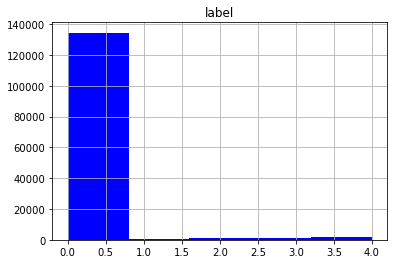

In [66]:
pd.DataFrame(labels).hist(bins=5,color='blue' )

In [67]:
X_train, X_test, y_train, y_test = train_test_split( data, labels, test_size=0.1, random_state=42)

In [68]:
X_train, X_val, y_train, y_val= train_test_split( X_train, y_train, test_size=0.1, random_state=42)

In [69]:
print(len(X_train.shape), len(X_test.shape), len(X_val.shape))
X_train.shape

2 2 2


(112387, 24)

In [70]:
y_train

82017     0
124830    0
109508    0
55836     0
89609     0
         ..
112224    0
106279    0
36226     0
95564     0
55841     0
Name: label, Length: 112387, dtype: int64

In [71]:
model = ak.AutoModel(
    inputs=[ak.StructuredDataInput()],
    outputs=[ak.RegressionHead()],
    max_trials=5,
    overwrite = True
)


In [72]:
model.fit(
    x=X_train, y=y_train, epochs=100, batch_size=128, validation_data= [X_val, y_val]
)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
structured_data...|False             |?                 
structured_data...|2                 |?                 
structured_data...|False             |?                 
structured_data...|0                 |?                 
structured_data...|32                |?                 
structured_data...|32                |?                 
regression_head...|0.25              |?                 
optimizer         |adam              |?                 
learning_rate     |0.001             |?                 

Epoch 1/100


FailedPreconditionError: Graph execution error:

Detected at node 'model/multi_category_encoding/string_lookup_7/None_Lookup/LookupTableFindV2' defined at (most recent call last):
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
      app.start()
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
      ret = callback()
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\tornado\gen.py", line 787, in inner
      self.run()
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\tornado\gen.py", line 748, in run
      yielded = self.gen.send(value)
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\ipykernel\kernelbase.py", line 545, in execute_request
      user_expressions, allow_stdin,
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\IPython\core\interactiveshell.py", line 2877, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\IPython\core\interactiveshell.py", line 2922, in _run_cell
      return runner(coro)
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\IPython\core\interactiveshell.py", line 3146, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\knabp_000\anaconda3\envs\BA_AI\lib\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-72-34b1a79c5d61>", line 2, in <module>
      x=X_train, y=y_train, epochs=100, batch_size=128, validation_data= [X_val, y_val]
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\autokeras\auto_model.py", line 285, in fit
      **kwargs
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\autokeras\engine\tuner.py", line 138, in search
      super().search(epochs=epochs, callbacks=new_callbacks, **fit_kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\kerastuner\engine\base_tuner.py", line 131, in search
      self.run_trial(trial, *fit_args, **fit_kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\kerastuner\engine\tuner.py", line 172, in run_trial
      self._build_and_fit_model(trial, fit_args, copied_fit_kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\kerastuner\engine\tuner.py", line 141, in _build_and_fit_model
      return model.fit(*fit_args, **fit_kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\engine\functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\autokeras\keras_layers.py", line 59, in call
      for input_node, encoding_layer in zip(split_inputs, self.encoding_layers):
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\autokeras\keras_layers.py", line 60, in call
      if encoding_layer is None:
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\autokeras\keras_layers.py", line 68, in call
      output_nodes.append(tf.cast(encoding_layer(input_node), tf.float32))
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\layers\preprocessing\index_lookup.py", line 628, in call
      lookups = self._lookup_dense(inputs)
    File "C:\Users\knabp_000\AppData\Roaming\Python\Python37\site-packages\keras\layers\preprocessing\index_lookup.py", line 657, in _lookup_dense
      lookups = self.lookup_table.lookup(inputs)
Node: 'model/multi_category_encoding/string_lookup_7/None_Lookup/LookupTableFindV2'
Table not initialized.
	 [[{{node model/multi_category_encoding/string_lookup_7/None_Lookup/LookupTableFindV2}}]] [Op:__inference_train_function_10647]

In [ ]:
model = model.export_model()


try:
    model.save("model_autokeras", save_format="tf")
except Exception:
    model.save("model_autokeras.h5")

In [ ]:
to_test = X_test
truth = y_test

res = np.round(model.predict(to_test))
info = pd.DataFrame(to_test)
stand = pd.DataFrame()
stand["userID"] = info[[0]]
stand["itemID"] = info[[1]]
pred = stand.copy()
gold = stand.copy()
pred["prediction"] = np.round(lenc.inverse_transform((res.astype(int))))
gold["prediction"] = np.round(truth)

In [ ]:
def count_points(pred, gold):
    df = pd.merge(pred, gold, on=['userID', 'itemID'], suffixes=('_pred', '_gold'))
    df['points'] = df.apply(_compute_points_for_row, axis=1)
    return df['points'].sum()

def _compute_points_for_row(row):
    y_pred, y_gold = row.prediction_pred, row.prediction_gold
    if y_pred == y_gold:
        # one point if "no order" (0) is predicted correctly; three points if order week is predicted correctly
        return 1 if y_pred == 0 else 3
    # one point if order is predicted correctly (but not the correct week), otherwise zero points
    return 1 if (y_pred > 0 and y_gold > 0) else 0

In [ ]:
points = count_points(pred, gold)
max_points = count_points(gold, gold)
score = points / max_points

In [ ]:
print(points)
print(max_points)
print(score)

In [ ]:
print(points)
print(max_points)
print(score)

In [ ]:
sns.set(style='darkgrid',font_scale=1.3, rc={'figure.figsize':(15,15)})
ax=pred["prediction"].hist(bins=2,color='blue' )